<a href="https://colab.research.google.com/github/simon-m-mudd/physical_geography_practicals/blob/main/physical_geography_flood_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical Geography practical 1: Analysis of flood data (and your first look at python)

Written by Simon M Mudd, last update 31-Jan-2024

## Overview

In this practical we will work with some data that comes from the National River Flow Archive (NFRA) which can be found at: https://nrfa.ceh.ac.uk/

The practical shows you how to perform flood frequency analysis, and then look at the results.

It will also give you a basic overview of python. We will use this again later in the course.

## What is this notebook?

You are reading this practical in something called an ipython notebook. The "i" is for "interactive", the "python" is a programming language.

If you are doing a degree in the School of GeoSciences at the University of Edinburgh, you will take some classes about the python programming language. This is not one of those courses.

In this course I just want you to look at data. In the past we have used spreadsheet programs (i.e., excel) for this. But graphs made here look better, and these notebooks are more flexible.

### The only thing you need to know about python programming at this stage

This notebook is organised into "cells".

* Some of the cells just contain text.
* Some contain python code that does something

You don't change the text cells.
For the python cells you just make them run.

**In Noteable** python cells have **In []:** written next to them.

**In Google colab** python cells have a symbol that looks like a "play" button if you hover over them.

In both of these environments, if you click on the cell and then type `shift+enter` the cell will run.


In [2]:
print("You just ran some python code! You can now put `Data Scientist` into you Linkedin profile!")

You just ran some python code! You can now put `Data Scientist` into you Linkedin profile!


## On to the practial!

### What is the NRFA

You can read the website: https://nrfa.ceh.ac.uk/

But the NRFA contains data from gauging stations distributed around the UK. A gauging station is a place where hydrologists measure flow. Usually they do some very labour intensive measurements of discharge (that is, the volume of water per unit of time, usually reported in m$^3$/s), and then relate this to the "stage" of the river (that is, the elevation of the water surface).

The relationship between the stage and the discharge is called a **rating curve**. Hydrolgists make rating curves because stage is much easier to measure than discharge.

You can find out the data about the gauging stations in the NRFA catalogue. But for now all you need to know is each station has a **station ID**, which is just a number.

For example, station 8010 is the River Spey at Grantown

### Get some data from the NFRA!

Now lets get some data from the National River Flow archive (NRFA).

We use a little python tool for this (you need to be connected to the internet).

The next bit of code installs the tool. Run the next cell.

In [3]:
!pip install nrfapy &> /dev/null

Now lets get some data.

We are going to get the annual maximum flow. This is the peak discharge at the station for that water year. The standard UK water-year begins on 1st October: for example the 1999 water year begins on 1/10/1999 and ends on 30/9/2000. Choosing the end of September as the end of the water year avoids splitting the data series at a flood-prone time of year.

In the following example I am getting the station number 8010 (see above) and I am getting the `amax-flow` data, which is the annual maximum flow. There are other options but you don't need to worry about them.

In [4]:
import nrfapy

station = 8010
data_type = "amax-flow"
amax_flow_df = nrfapy.get_ts(station,data_type)
amax_flow_df.head()

,time,amax-flow
0,1952-01-15T00:00:00,123.539
1,1953-09-02T00:00:00,165.870
2,1953-12-03T00:00:00,205.130
3,1954-12-04T00:00:00,296.139
4,1956-08-14T00:00:00,296.139


Just to develop some physical intuition about discharge: a lowland river might flow 1 metre per second at low flows, and you might get over 3 m/s during a flood. The station on this part to the Spey is 60m wide. For a discharge of 300 m$^3$/s, a velocity of 3m/s, and a width of 60m, you would get a water depth of 1.66m. We can look at the stage measurement (how deep the river is during the flood) to check our estimates:

In [5]:
data_type = "amax-stage"
amax_stage_df = nrfapy.get_ts(station,data_type)
amax_stage_df.head()

,time,amax-stage
0,1952-01-15T00:00:00,1.06
1,1953-09-02T00:00:00,1.28
2,1953-12-03T00:00:00,1.46
3,1954-12-04T00:00:00,1.82
4,1956-08-14T00:00:00,1.82


Hey, not bad!

We can also plot the maximum disharge from each year's flood.

Again, you don't need to change anything below, just click on the cells and type shift+enter to run them.

In [6]:
import pandas as pd

# Convert 'datetime' column to datetime format
amax_flow_df['datetime'] = pd.to_datetime(amax_flow_df['time'], format='%Y-%m-%dT%H:%M:%S')


# Extract the year from the datetime column
amax_flow_df['year'] = amax_flow_df['datetime'].dt.year

amax_flow_df.head()

,time,amax-flow,datetime,year
0,1952-01-15T00:00:00,123.539,1952-01-15,1952
1,1953-09-02T00:00:00,165.870,1953-09-02,1953
2,1953-12-03T00:00:00,205.130,1953-12-03,1953
3,1954-12-04T00:00:00,296.139,1954-12-04,1954
4,1956-08-14T00:00:00,296.139,1956-08-14,1956


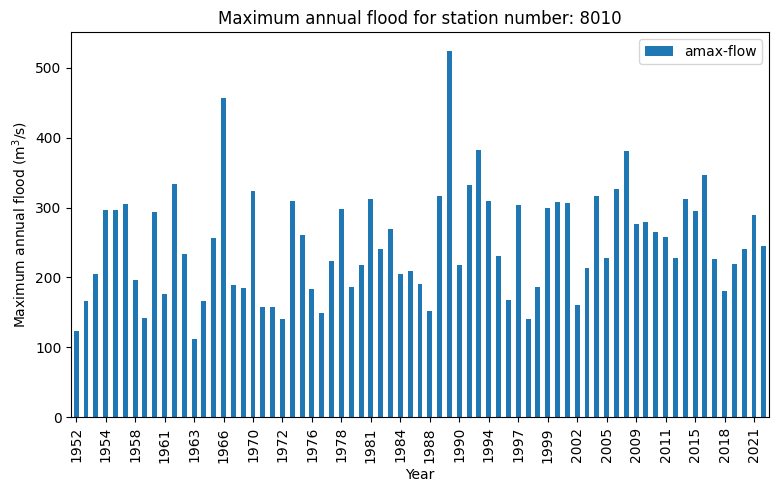

In [7]:
import matplotlib.pyplot as plt

# This makes a bar plot
ax = amax_flow_df.plot.bar(x='year', y='amax-flow', rot=90, figsize=(9, 5))

# Set x-axis label to be the year
plt.xlabel('Year')

# Set y-axis label
plt.ylabel('Maximum annual flood (m$^3$/s)')

# Set the title
plt.title('Maximum annual flood for station number: '+str(station))

# Show every 3rd label on the x-axis
plt.xticks(amax_flow_df["amax-flow"].index[::3]);

### Now for flood frequency

Now we are going to look at the flood frequency.

Before we do the formal flood frequency analysis we will calculate some simple statistics of the floods. First lets look at the probability of annual maximum discharges.

We do this using something called a kernal density estimation, which is a method to estimate the probability density of a dataset.

Text(0.5, 1.0, 'Probability density of annual maximum discharge (in m$^3$/s) for station number: 8010')

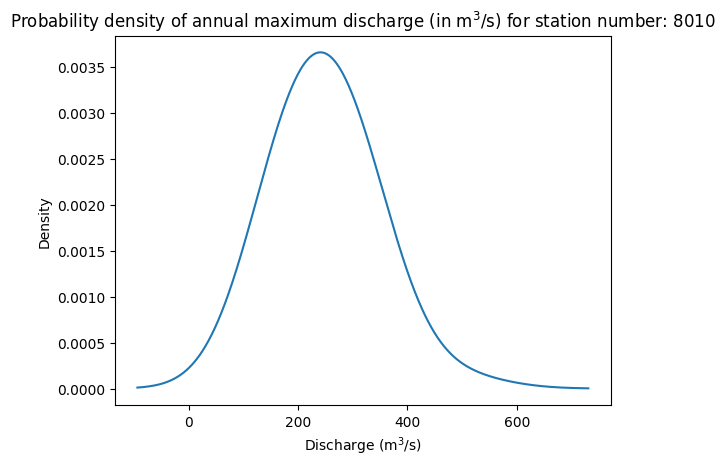

In [8]:
ax = amax_flow_df['amax-flow'].plot.kde(bw_method=1)

# Set x-axis label to be the year
plt.xlabel('Discharge (m$^3$/s)')

# Set the title
plt.title('Probability density of annual maximum discharge (in m$^3$/s) for station number: '+str(station))

We can also get the average and median values

In [9]:
mean_amax_Q = amax_flow_df['amax-flow'].mean()
median_amax_Q = amax_flow_df['amax-flow'].median()
print("The mean annual maximum flow is: " +str(mean_amax_Q) + " m^3/s and the median is: " + str(median_amax_Q)+ " m^3/s")

The mean annual maximum flow is: 248.4422112676056 m^3/s and the median is: 240.878 m^3/s


To do flood frequency analysis, we need to rank the floods, with the largest flood ranked 1, the second largest 2, and so on. There is a `pandas` script for that:

In [10]:
amax_flow_df['rank_column'] = amax_flow_df['amax-flow'].rank(ascending=False).astype(int)
amax_flow_df.head(10)

,time,amax-flow,datetime,year,rank_column
0,1952-01-15T00:00:00,123.539,1952-01-15,1952,70
1,1953-09-02T00:00:00,165.870,1953-09-02,1953,60
2,1953-12-03T00:00:00,205.130,1953-12-03,1953,49
3,1954-12-04T00:00:00,296.139,1954-12-04,1954,22
4,1956-08-14T00:00:00,296.139,1956-08-14,1956,22
5,1956-12-15T00:00:00,304.474,1956-12-15,1956,18
6,1958-07-28T00:00:00,196.045,1958-07-28,1958,50
7,1959-01-19T00:00:00,142.009,1959-01-19,1959,67
8,1960-08-25T00:00:00,293.386,1960-08-25,1960,25
9,1961-08-09T00:00:00,176.358,1961-08-09,1961,58


We need to know how many records there are, the ode for that is below.

In [11]:
n_records = len(amax_flow_df['amax-flow'])
print("The number of years on record is: "+str(n_records))


The number of years on record is: 71


#### Calculating return period

The return period, *R*, is calculated using the following equation:

$R = \frac{n+1}{n}$

where *R* is the return period (in years), *n* is the number of years on record, and *m* is the rank of the flood in the *n* year record.

So we need to divide (*n*+1) (for station 8010 this is 71) by each year's rank, which again is quite easy using `pandas`:

In [12]:
amax_flow_df['return_period'] = (n_records+1)/amax_flow_df['rank_column']
amax_flow_df.head(10)

,time,amax-flow,datetime,year,rank_column,return_period
0,1952-01-15T00:00:00,123.539,1952-01-15,1952,70,1.028571
1,1953-09-02T00:00:00,165.870,1953-09-02,1953,60,1.200000
2,1953-12-03T00:00:00,205.130,1953-12-03,1953,49,1.469388
3,1954-12-04T00:00:00,296.139,1954-12-04,1954,22,3.272727
4,1956-08-14T00:00:00,296.139,1956-08-14,1956,22,3.272727
5,1956-12-15T00:00:00,304.474,1956-12-15,1956,18,4.000000
6,1958-07-28T00:00:00,196.045,1958-07-28,1958,50,1.440000
7,1959-01-19T00:00:00,142.009,1959-01-19,1959,67,1.074627
8,1960-08-25T00:00:00,293.386,1960-08-25,1960,25,2.880000
9,1961-08-09T00:00:00,176.358,1961-08-09,1961,58,1.241379


#### Make a flood frequency plot

Lets now plot the return period against the discharge:

Text(0.5, 1.0, 'Return periods for station number: 8010')

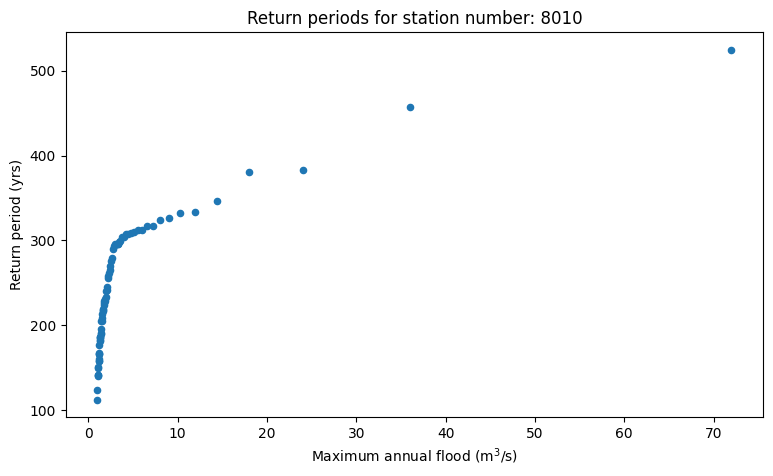

In [13]:
import matplotlib.pyplot as plt

# This makes a bar plot
ax = amax_flow_df.plot.scatter(x='return_period', y='amax-flow', figsize=(9, 5))

# Set x-axis label to be the year
plt.xlabel('Maximum annual flood (m$^3$/s)')

# Set y-axis label
plt.ylabel('Return period (yrs)')

# Set the title
plt.title('Return periods for station number: '+str(station))


This actually looks better if you set the x axis to be in logarithmic scale.

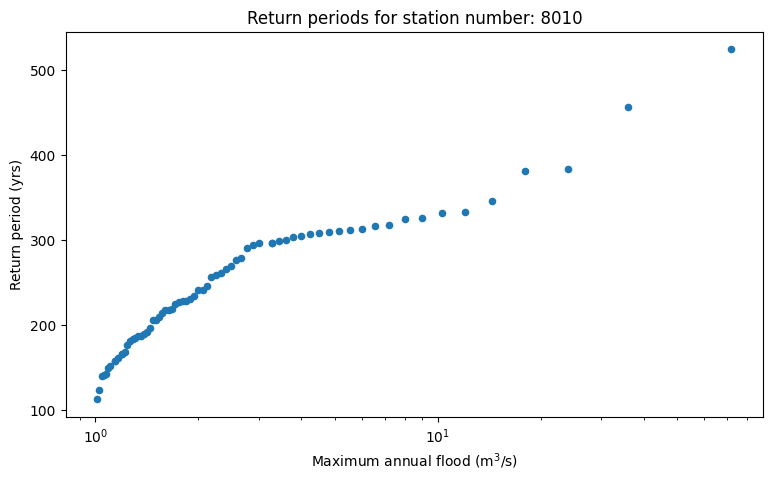

In [14]:
import matplotlib.pyplot as plt

# This makes a bar plot
ax = amax_flow_df.plot.scatter(x='return_period', y='amax-flow', figsize=(9, 5))

# Set x-axis label to be the year
plt.xlabel('Maximum annual flood (m$^3$/s)')

# Set y-axis label
plt.ylabel('Return period (yrs)')

# Set the title
plt.title('Return periods for station number: '+str(station))

# Set x-axis to logarithmic scale
ax.set_xscale('log')

We can fit that data with an equation of the form:

$Q_{flood} = a \ln (R)+b$

where ln is the natural logarithm and a and b are some constants you fit.

We can do that in `pandas` and by using some python statistics tools.

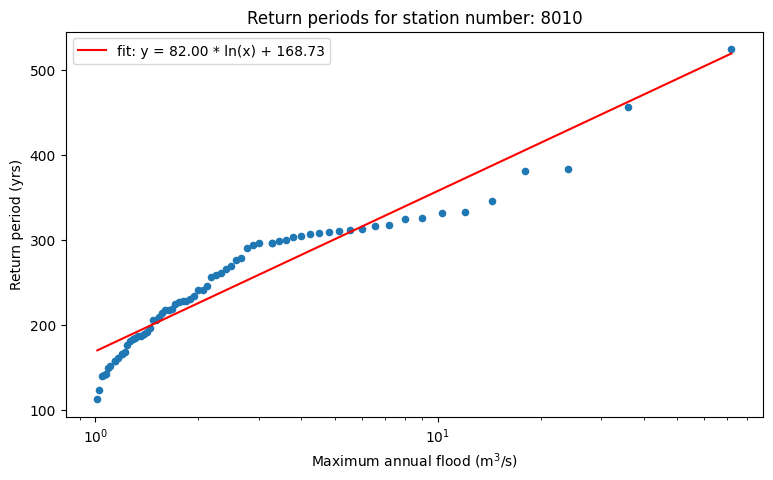

In [15]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# This makes a scatter plot
ax = amax_flow_df.plot.scatter(x='return_period', y='amax-flow', figsize=(9, 5))

# Set x-axis label
plt.xlabel('Maximum annual flood (m$^3$/s)')

# Set y-axis label
plt.ylabel('Return period (yrs)')

# Set the title
plt.title('Return periods for station number: '+str(station))

# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Perform a linear regression on the natural log of the x data
slope, intercept, r_value, p_value, std_err = linregress(np.log(amax_flow_df['return_period']), amax_flow_df['amax-flow'])

# Create a range of x values for the fitted line
x_fit = np.linspace(min(amax_flow_df['return_period']), max(amax_flow_df['return_period']), num=500)

# Calculate the corresponding y values for the fitted line
y_fit = slope * np.log(x_fit) + intercept

# Plot the fitted line
plt.plot(x_fit, y_fit, 'r', label=f'fit: y = {slope:.2f} * ln(x) + {intercept:.2f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()


At this point you may be looking at this code and wondering "how on Earth will I be able to remember all these python things?"

The author of this notebook is not bad at python but as recently as 2022 would need to spend some time refreshing his memory on Stackoverflow. But now we have AI: I just had the code from the previous cell and asked Microsoft Bard this question:

*How do I add a trendline to that plot. I want to fit it with a natural log regression?*

Unless you are doing something quite niche, AI can write functional python code for basic data analysis.

#### Find the return period of the mean annual flood

Okay, lets get the return period of the mean annual flood. The mean annual flood is specifically the mean value of all the amax-flow data, which you calculated earlier. We can calulate it by reorganising the regression equation:


$\frac{Q_{flood}-b}{a} = \ln (R)$

which with some more algebra is
$R = exp[ \frac{Q_{flood}-b}{a}]$

In [16]:
R_maf = np.exp( (mean_amax_Q - intercept) / slope)
print("The return period of the mean annual flood is: "+str(R_maf))

The return period of the mean annual flood is: 2.643460193790987


And we can also predict much bigger floods, by taking that original equation:

$Q_{flood} = a \ln (R)+b$

and plugging in big return periods. Lets see how big a 500 year flood is:

In [17]:
big_return_period = 500
flood_big = slope*np.log(big_return_period)+ intercept
print("The discharge of a flood with a return period of "+str(big_return_period)+ " years is "+str(flood_big) + "m^3/s")

The discharge of a flood with a return period of 500 years is 678.3335481559477m^3/s


## Getting information about the stations

So we have looked at a single station (station number 8010, the River Spey at Grantown). You might want to search for stations on your favourite river. For this we need to look at the NRFA catalogue.

We can get this with a line of python: `stations_data = nrfapy.catalogue()`

After that we use `pandas` to search the data. The `head()` command below shows you the first few lines of the data and what the column names are.

In [18]:
import nrfapy
stations_data = nrfapy.catalogue()
stations_data.head()

,id,name,catchment-area,grid-reference,easting,northing,lat-long,latitude,longitude,river,...,peak-flow-rejected-amax-years,peak-flow-rejected-periods,data-summary,licence-url,description-summary,description-general,description-station-hydrometry,description-flow-record,description-catchment,description-flow-regime
0,1001,Wick at Tarroul,161.9,"{'ngr': 'ND2620254915', 'easting': 326202.0, '...",326202.0,954915.0,"{'string': '58°28'34.3048""N 3°16'01.4180""W', '...",58.47620,-3.26706,Wick,...,None,None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station gauging a catchment in t...,Velocity area station in relatively straight (...,Cableway present. Rarely by-passed; MAF probab...,None,Relatively dry and flat catchment given over l...,Natural flow regime.
1,2001,Helmsdale at Kilphedir,551.4,"{'ngr': 'NC9983918163', 'easting': 299839.0, '...",299839.0,918163.0,"{'string': '58°08'27.6037""N 3°42'10.6144""W', '...",58.14100,-3.70295,Helmsdale,...,{'excluded-years': [1974]},None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station in upland Scotland. Flow...,Velocity area station; approx. 35m wide river ...,Stable gravel control. Two peak flow rating ac...,Full period of record peak flow data reviewed ...,Typical Scottish upland impermeable bedrock he...,Loch Badanloch and an-Ruathair used for river ...
2,2002,Brora at Bruachrobie,434.4,"{'ngr': 'NC8915603916', 'easting': 289156.0, '...",289156.0,903916.0,"{'string': '58°00'38.0048""N 3°52'39.2357""W', '...",58.01056,-3.87757,Brora,...,{'excluded-years': [1992]},None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station in upland Scotland. Main...,Velocity area station about 40m wide with rela...,Ratings derived from current meter gaugings up...,Full period of record peak flow data reviewed ...,"Mountainous headwaters, often snowy in winter....",Mainly natural regime. Small headwater diversi...
3,3001,Shin at Lairg,494.6,"{'ngr': 'NC581062', 'easting': 258100.0, 'nort...",258100.0,906200.0,"{'string': '58°01'19.9838""N 4°24'14.5766""W', '...",58.02222,-4.40405,Shin,...,None,None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Station measuring flows between Loch Shin and ...,River section between main Loch Shin (HEP) dam...,None,1953-56 data pre-dates the start of impoundmen...,None,None
4,3002,Carron at Sgodachail,241.1,"{'ngr': 'NH4913692152', 'easting': 249136.0, '...",249136.0,892152.0,"{'string': '57°53'35.5581""N 4°32'48.0657""W', '...",57.89321,-4.54668,Carron,...,{'excluded-years': [1973]},None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station. Low and medium flows af...,Velocity area station; river section about 35m...,Gravel bed with problems of stability in low f...,Full period of record peak flow data reviewed ...,Approx. 80% of this remote Highland catchment ...,Computed low flows are natural in relation to ...


You can search for an individual station by using the line below.

Try to change the number from 8010.

If you use a number that does not correspond to a station you will get an empty row.

**Do not change anything else in the code cell!**

In [19]:
stations_data.loc[stations_data['id'] == 8010]

,id,name,catchment-area,grid-reference,easting,northing,lat-long,latitude,longitude,river,...,peak-flow-rejected-amax-years,peak-flow-rejected-periods,data-summary,licence-url,description-summary,description-general,description-station-hydrometry,description-flow-record,description-catchment,description-flow-regime
53,8010,Spey at Grantown,1748.8,"{'ngr': 'NJ0328226785', 'easting': 303282.0, '...",303282.0,826785.0,"{'string': '57°19'16.7743""N 3°36'27.6230""W', '...",57.32133,-3.60767,Spey,...,{'excluded-years': [1951]},None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station. Part of the catchment i...,Velocity area station about 60m wide.,Cableway rated with natural control. Improved ...,Full period of record peak flow data reviewed ...,"Upland catchment, often snowy in winter. Grani...",Loch Insh and Insh Marshes: at high flows floo...


You can then use the below query to get all the stations on your favourite river.

Try changing the name of the river!

In [20]:
stations_data[stations_data['river'].str.contains("Spey")]

,id,name,catchment-area,grid-reference,easting,northing,lat-long,latitude,longitude,river,...,peak-flow-rejected-amax-years,peak-flow-rejected-periods,data-summary,licence-url,description-summary,description-general,description-station-hydrometry,description-flow-record,description-catchment,description-flow-regime
44,8001,Spey at Aberlour,2654.7,"{'ngr': 'NJ2778543972', 'easting': 327785.0, '...",327785.0,843972.0,"{'string': '57°28'48.7849""N 3°12'21.5105""W', '...",57.48022,-3.20598,Spey,...,None,None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station in largely mountainous c...,Velocity area station about 45 m wide. Removed...,Natural control. Bank collapse in 1995 blocked...,Daily flows not archived since 1974.,Catchment is largely mountainous (includes all...,15% of catchment controlled for HEP production...
45,8002,Spey at Kinrara,1011.7,"{'ngr': 'NH8809908201', 'easting': 288099.0, '...",288099.0,808201.0,"{'string': '57°09'03.6087""N 3°51'04.5609""W', '...",57.15100,-3.85127,Spey,...,None,None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station with headwaters in the C...,Velocity area station about 50m wide. Station ...,Natural control. Cableway rated to bankfull. W...,Flow of 232 cumecs gauged in both 1962 and 200...,"Mountainous headwaters, often snowy in winter....",380 sq km developed for hydro-power with diver...
46,8003,Spey at Ruthven Bridge,533.8,"{'ngr': 'NN759996', 'easting': 275900.0, 'nort...",275900.0,799600.0,"{'string': '57°04'14.3486""N 4°02'54.5970""W', '...",57.07065,-4.04850,Spey,...,None,None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station with some of the catchme...,Velocity area station with some of the catchme...,None,None,None,287 sq km controlled for HEP production; major...
48,8005,Spey at Boat of Garten,1267.8,"{'ngr': 'NH9469119208', 'easting': 294691.0, '...",294691.0,819208.0,"{'string': '57°15'05.0103""N 3°44'49.3034""W', '...",57.25139,-3.74703,Spey,...,None,None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station with some of the catchme...,Velocity area station. Station re-located d/s ...,Cableway rated. Natural control and relatively...,Full period of record peak flow data reviewed ...,Upland catchment with mountainous headwaters o...,Loch Insh and Insh marshes may influence flood...
49,8006,Spey at Boat o Brig,2861.2,"{'ngr': 'NJ3185051788', 'easting': 331850.0, '...",331850.0,851788.0,"{'string': '57°33'03.7481""N 3°08'25.3970""W', '...",57.55104,-3.14039,Spey,...,{'excluded-years': [1951]},None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,"Velocity area station, the most downstream sta...",Velocity area station 65m wide. Cableway rated...,Natural control. Floods above 2.5m bypass stat...,Full period of record peak flow data reviewed ...,Mountainous catchment (includes all north slop...,Storage at Loch Insh and Insh marshes - at hig...
50,8007,Spey at Invertruim,400.4,"{'ngr': 'NN6876196425', 'easting': 268761.0, '...",268761.0,796425.0,"{'string': '57°02'24.6183""N 4°09'52.1814""W', '...",57.04017,-4.16449,Spey,...,"{'excluded-years': [1994, 1995, 1996, 1997]}",{'rejected-periods': ['1995-01-01/1998-10-01']},"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station. The highest station on ...,"Velocity area station, 45m wide Cableway rated...",Natural control; frequent rating changes. Bypa...,Unrepresentative period from 01/01/95 to 28/10...,"Mountainous headwaters, often snowy in winter....",200.4 sq.km controlled for HEP by British Alum...
53,8010,Spey at Grantown,1748.8,"{'ngr': 'NJ0328226785', 'easting': 303282.0, '...",303282.0,826785.0,"{'string': '57°19'16.7743""N 

### Plot station locations

We might want to see where these stations are.

We can plot them on a map, but first we need to install something called contextily, which is a nice package for showing basemaps. You don't need to worry about that at this point.

In [21]:
!pip install contextily &> /dev/null

In [22]:
import geopandas as gpd
import contextily as ctx

# Make a dataframe with just the stations on the Spey.
my_stations = stations_data[stations_data['river'].str.contains("Spey")]

# Now we use the British National Grid coordinates
# Every coordinate reference system (crs) has a code. The british national grid's code is EPSG:27700
gdf2 = gpd.GeoDataFrame(my_stations, geometry=gpd.points_from_xy(my_stations.easting, my_stations.northing), crs='EPSG:27700')

# You could also do this with latitude and longitude, but it results in a slightly distorted map
#gdf = gpd.GeoDataFrame(my_stations, geometry=gpd.points_from_xy(my_stations.longitude, my_stations.latitude), crs='EPSG:4326')


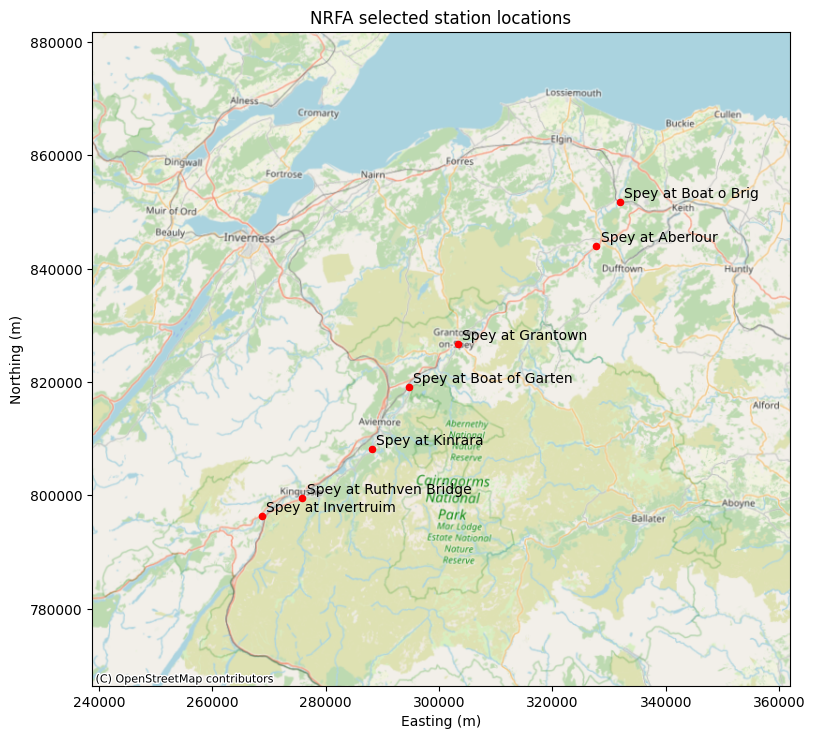

In [23]:
# Create a plot using geopands
ax = gdf2.plot(marker='o', color='red', markersize=20, figsize=(9, 9))


# This labels the stations
for x, y, label in zip(gdf2.geometry.x, gdf2.geometry.y, gdf2.name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

# The plot looks better if you pad the points by 30km
# The next three lines to that. If you want to change the padding only change
# the "padding" number
padding = 30000
xlim = (gdf2.total_bounds[0] - padding, gdf2.total_bounds[2] + padding)
ylim = (gdf2.total_bounds[1] - padding, gdf2.total_bounds[3] + padding)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Now add a basemap
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik,crs=gdf2.crs.to_string())

# Set axis labels and title
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('NRFA selected station locations')

# Show the plot
plt.show()

If you want to play with this try doing all the above but just change the river name.

## Look at a few of your favourite rivers

Now you will test your ability to look at your own favourite river.

The steps are:
1. Search the catalog for the correct station number.
2. Change the station number when getting the data.
2. Make the rank column.
3. Get the mean annual flood.
3. Get the number of years on record from the data.
4. Calculate the return period.
5. Plot the return period and get the function that describes the flow as a function of return period.
6. Calculate the return period of the mean annual flood.
7. Get the flow of a big flood (say 500 year).


In [24]:
my_river = "Tay"
stations_data[stations_data['river'].str.contains(my_river)]

,id,name,catchment-area,grid-reference,easting,northing,lat-long,latitude,longitude,river,...,peak-flow-rejected-amax-years,peak-flow-rejected-periods,data-summary,licence-url,description-summary,description-general,description-station-hydrometry,description-flow-record,description-catchment,description-flow-regime
109,15003,Tay at Caputh,3210.0,"{'ngr': 'NO0828939575', 'easting': 308289.0, '...",308289.0,739575.0,"{'string': '56°32'21.1105""N 3°29'34.5931""W', '...",56.53920,-3.49294,Tay,...,None,None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station gauging a catchment with...,"Velocity area station, about 95m wide. Origina...","Cableway present, span 120m. Natural control. ...","Twice daily stage readings from July 1937, con...","Steep, mountainous headwaters, often snowy in ...",62% of catchment controlled for HEP; developed...
112,15006,Tay at Ballathie,4587.1,"{'ngr': 'NO14753668', 'easting': 314750.0, 'no...",314750.0,736680.0,"{'string': '56°30'51.8907""N 3°23'13.0704""W', '...",56.51441,-3.38696,Tay,...,None,None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,"Velocity area station, the most downstream on ...",Velocity area station with cableway; 90m wide....,Control is bed slope and channel cross-section...,Full period of record peak flow data reviewed ...,"Mountainous headwater catchment, often snowy i...","Since end of 1957, 1980 sq.km (43%) controlled..."
113,15007,Tay at Pitnacree,1149.4,"{'ngr': 'NN9240353411', 'easting': 292403.0, '...",292403.0,753411.0,"{'string': '56°39'36.2456""N 3°45'24.8449""W', '...",56.66007,-3.75690,Tay,...,None,None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,Velocity area station on the upper Tay. Part o...,"Velocity area station, about 90m wide.",Cableway present. Control is unstable gravel b...,Naturalised monthly flows available from 1973 ...,"Mountainous headwaters, often snowy in winter....",293 sq.km (25% of catchment) controlled for HE...
121,15016,Tay at Kenmore,600.9,"{'ngr': 'NN7821446706', 'easting': 278214.0, '...",278214.0,746706.0,"{'string': '56°35'46.9973""N 3°59'06.2224""W', '...",56.59639,-3.98506,Tay,...,{'excluded-years': [1974]},None,"{'data-types': [{'data-type': 'gdf', 'paramete...",http://eidc.ceh.ac.uk/administration-folder/to...,"Velocity area station in the upper Tay, 2km d/...","Velocity area station, about 60m wide.",Cableway present. Natural control. All flows c...,Daily gaugeboard readings 1959-1974. Naturalis...,The catchment is in the Grampians (rising up t...,Slow reacting regime. 120 sq km of the catchme...


Change the station number below.

In [25]:
import nrfapy

station = 15003
data_type = "amax-flow"
amax_flow_df = nrfapy.get_ts(station,data_type)
amax_flow_df.head()

,time,amax-flow
0,1951-11-05T22:30:00,1339.534
1,1952-10-29T12:00:00,560.335
2,1953-11-07T14:00:00,785.083
3,1954-12-04T15:00:00,1083.752
4,1955-12-28T02:00:00,914.756


Make the rank column

In [26]:
amax_flow_df['rank_column'] = amax_flow_df['amax-flow'].rank(ascending=False).astype(int)
amax_flow_df.head(10)

,time,amax-flow,rank_column
0,1951-11-05T22:30:00,1339.534,7
1,1952-10-29T12:00:00,560.335,66
2,1953-11-07T14:00:00,785.083,44
3,1954-12-04T15:00:00,1083.752,16
4,1955-12-28T02:00:00,914.756,31
5,1956-12-16T02:30:00,953.587,25
6,1957-12-20T14:45:00,804.334,43
7,1959-01-20T05:30:00,604.204,65
8,1959-12-07T12:30:00,753.829,46
9,1961-09-29T00:30:00,830.254,41


Get the number of years on record

In [27]:
n_records = len(amax_flow_df['amax-flow'])
print("The number of years on record is: "+str(n_records))


The number of years on record is: 71


Get the mean annual flood

In [28]:
mean_amax_Q = amax_flow_df['amax-flow'].mean()
median_amax_Q = amax_flow_df['amax-flow'].median()
print("The mean annual maximum flow is: " +str(mean_amax_Q) + " m^3/s and the median is: " + str(median_amax_Q)+ " m^3/s")

The mean annual maximum flow is: 901.6825492957747 m^3/s and the median is: 861.392 m^3/s


Calculate the return period

In [29]:
amax_flow_df['return_period'] = (n_records+1)/amax_flow_df['rank_column']
amax_flow_df.head(10)

,time,amax-flow,rank_column,return_period
0,1951-11-05T22:30:00,1339.534,7,10.285714
1,1952-10-29T12:00:00,560.335,66,1.090909
2,1953-11-07T14:00:00,785.083,44,1.636364
3,1954-12-04T15:00:00,1083.752,16,4.500000
4,1955-12-28T02:00:00,914.756,31,2.322581
5,1956-12-16T02:30:00,953.587,25,2.880000
6,1957-12-20T14:45:00,804.334,43,1.674419
7,1959-01-20T05:30:00,604.204,65,1.107692
8,1959-12-07T12:30:00,753.829,46,1.565217
9,1961-09-29T00:30:00,830.254,41,1.756098


Calculate the fit on the return period

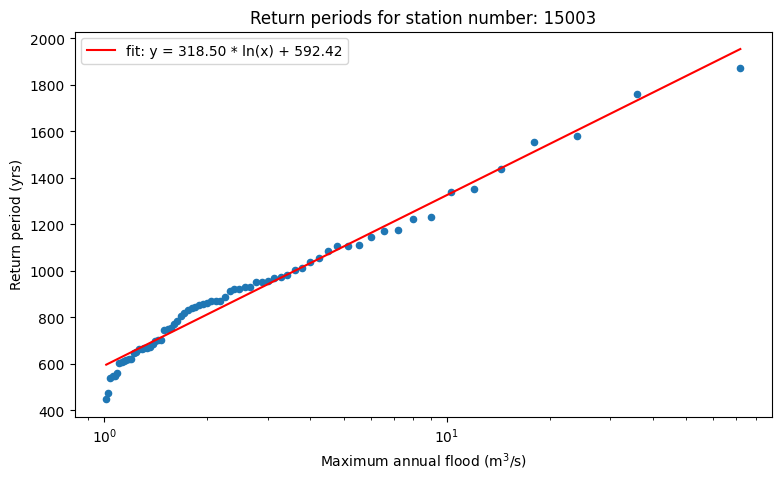

In [30]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# This makes a scatter plot
ax = amax_flow_df.plot.scatter(x='return_period', y='amax-flow', figsize=(9, 5))

# Set x-axis label
plt.xlabel('Maximum annual flood (m$^3$/s)')

# Set y-axis label
plt.ylabel('Return period (yrs)')

# Set the title
plt.title('Return periods for station number: '+str(station))

# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Perform a linear regression on the natural log of the x data
slope, intercept, r_value, p_value, std_err = linregress(np.log(amax_flow_df['return_period']), amax_flow_df['amax-flow'])

# Create a range of x values for the fitted line
x_fit = np.linspace(min(amax_flow_df['return_period']), max(amax_flow_df['return_period']), num=500)

# Calculate the corresponding y values for the fitted line
y_fit = slope * np.log(x_fit) + intercept

# Plot the fitted line
plt.plot(x_fit, y_fit, 'r', label=f'fit: y = {slope:.2f} * ln(x) + {intercept:.2f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [31]:
R_maf = np.exp( (mean_amax_Q - intercept) / slope)
print("The return period of the mean annual flood is: "+str(R_maf))

The return period of the mean annual flood is: 2.6406049598269474


In [44]:
big_return_period = 100
flood_big = slope*np.log(big_return_period)+ intercept
print("The discharge of a flood with a return period of "+str(big_return_period)+ " years is "+str(flood_big) + "m^3/s")

The discharge of a flood with a return period of 100 years is 1810.114541598097m^3/s


## Last steps

One of problem with this form of flood frequency analysis is that it is very sensitive to the number of years on record.  

In [54]:
station = 15003
data_type = "amax-flow"
amax_flow_df = nrfapy.get_ts(station,data_type)
amax_flow_df.head()

,time,amax-flow
0,1951-11-05T22:30:00,1339.534
1,1952-10-29T12:00:00,560.335
2,1953-11-07T14:00:00,785.083
3,1954-12-04T15:00:00,1083.752
4,1955-12-28T02:00:00,914.756


In [55]:
years_to_remove = 20
amax_flow_df_short = amax_flow_df.iloc[:-years_to_remove]

In [56]:
amax_flow_df_short['rank_column'] = amax_flow_df_short['amax-flow'].rank(ascending=False).astype(int)
amax_flow_df_short.head(10)

<ipython-input-56-a32e879f4374>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amax_flow_df_short['rank_column'] = amax_flow_df_short['amax-flow'].rank(ascending=False).astype(int)


,time,amax-flow,rank_column
0,1951-11-05T22:30:00,1339.534,3
1,1952-10-29T12:00:00,560.335,47
2,1953-11-07T14:00:00,785.083,29
3,1954-12-04T15:00:00,1083.752,11
4,1955-12-28T02:00:00,914.756,19
5,1956-12-16T02:30:00,953.587,16
6,1957-12-20T14:45:00,804.334,28
7,1959-01-20T05:30:00,604.204,46
8,1959-12-07T12:30:00,753.829,30
9,1961-09-29T00:30:00,830.254,26


In [57]:
n_records = len(amax_flow_df_short['amax-flow'])
print("The number of years on record is: "+str(n_records))

The number of years on record is: 51


In [58]:
amax_flow_df_short['return_period'] = (n_records+1)/amax_flow_df_short['rank_column']
amax_flow_df_short.head(10)

<ipython-input-58-8acf1cd0e71c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amax_flow_df_short['return_period'] = (n_records+1)/amax_flow_df_short['rank_column']


,time,amax-flow,rank_column,return_period
0,1951-11-05T22:30:00,1339.534,3,17.333333
1,1952-10-29T12:00:00,560.335,47,1.106383
2,1953-11-07T14:00:00,785.083,29,1.793103
3,1954-12-04T15:00:00,1083.752,11,4.727273
4,1955-12-28T02:00:00,914.756,19,2.736842
5,1956-12-16T02:30:00,953.587,16,3.250000
6,1957-12-20T14:45:00,804.334,28,1.857143
7,1959-01-20T05:30:00,604.204,46,1.130435
8,1959-12-07T12:30:00,753.829,30,1.733333
9,1961-09-29T00:30:00,830.254,26,2.000000


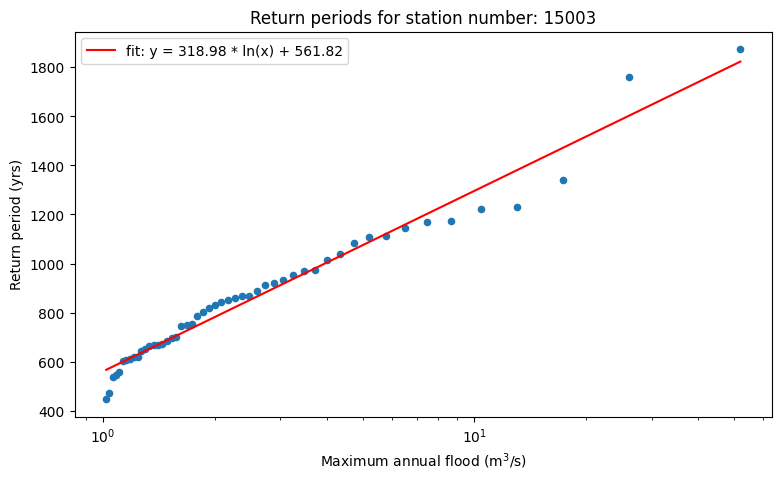

In [59]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# This makes a scatter plot
ax = amax_flow_df_short.plot.scatter(x='return_period', y='amax-flow', figsize=(9, 5))

# Set x-axis label
plt.xlabel('Maximum annual flood (m$^3$/s)')

# Set y-axis label
plt.ylabel('Return period (yrs)')

# Set the title
plt.title('Return periods for station number: '+str(station))

# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Perform a linear regression on the natural log of the x data
sslope, sintercept, sr_value, sp_value, sstd_err = linregress(np.log(amax_flow_df_short['return_period']), amax_flow_df_short['amax-flow'])

# Create a range of x values for the fitted line
x_fit = np.linspace(min(amax_flow_df_short['return_period']), max(amax_flow_df_short['return_period']), num=500)

# Calculate the corresponding y values for the fitted line
y_fit = sslope * np.log(x_fit) + sintercept

# Plot the fitted line
plt.plot(x_fit, y_fit, 'r', label=f'fit: y = {sslope:.2f} * ln(x) + {sintercept:.2f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [60]:
big_return_period = 100
flood_big = sslope*np.log(big_return_period)+ sintercept
print("The discharge of a flood with a return period of "+str(big_return_period)+ " years is "+str(flood_big) + "m^3/s")

The discharge of a flood with a return period of 100 years is 2030.7697401392727m^3/s
